In [26]:
# ========================================================
# NDVI Time Series Classification with Logistic Regression
# Advanced Solution for Land Cover Classification
# ========================================================

# Importing Required Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Libraries imported successfully!")


Libraries imported successfully!


In [35]:
# Load the training and test data
df_test = pd.read_csv("/kaggle/input/testtt/hacktest.csv")
df_train = pd.read_csv("/kaggle/input/test-data/hacktrain.csv")
print(f"Training data shape: {df_train.shape}")
print(f"Test data shape: {df_test.shape}")

# --- CRITICAL STEP: Separate features (X) from target (y) immediately ---
try:
    # Isolate the target variable from the training data
    y_train = df_train['class']
    
    # Create the feature matrix by dropping the target variable
    # Also drop non-feature columns like ID
    X_train_raw = df_train.drop(columns=['class', 'ID', 'Unnamed: 0'], errors='ignore')
    
    # Prepare the test feature matrix (it doesn't have a 'class' column)
    X_test_raw = df_test.drop(columns=['ID', 'Unnamed: 0'], errors='ignore')

    print("\nSuccessfully separated features (X) and target (y).")
    print(f"Shape of X_train_raw: {X_train_raw.shape}")
    print(f"Shape of y_train: {y_train.shape}")
    print(f"Shape of X_test_raw: {X_test_raw.shape}")

except KeyError:
    print("\nFATAL ERROR: The 'class' column is missing from your 'hacktrain.csv' file.")
    print("Please ensure your training CSV file contains the target variable.")
    # Stop execution by raising the error
    raise


Training data shape: (8000, 30)
Test data shape: (2845, 29)

Successfully separated features (X) and target (y).
Shape of X_train_raw: (8000, 27)
Shape of y_train: (8000,)
Shape of X_test_raw: (2845, 27)


In [36]:
def extract_time_series_features(df_in):
    """
    Extracts a rich set of features from the NDVI time series data.
    """
    ndvi_cols = [col for col in df_in.columns if '_N' in col]
    features = pd.DataFrame(index=df_in.index)
    
    # Statistical Features
    features['ndvi_mean'] = df_in[ndvi_cols].mean(axis=1)
    features['ndvi_std'] = df_in[ndvi_cols].std(axis=1)
    features['ndvi_min'] = df_in[ndvi_cols].min(axis=1)
    features['ndvi_max'] = df_in[ndvi_cols].max(axis=1)
    features['ndvi_range'] = features['ndvi_max'] - features['ndvi_min']
    features['ndvi_median'] = df_in[ndvi_cols].median(axis=1)
    
    # Percentile Features
    features['ndvi_25pct'] = df_in[ndvi_cols].quantile(0.25, axis=1)
    features['ndvi_75pct'] = df_in[ndvi_cols].quantile(0.75, axis=1)
    features['ndvi_iqr'] = features['ndvi_75pct'] - features['ndvi_25pct']
    
    # Indicator Features
    features['ndvi_neg_count'] = (df_in[ndvi_cols] < 0).sum(axis=1)
    features['ndvi_high_count'] = (df_in[ndvi_cols] > 2000).sum(axis=1)
    
    # Seasonal Features
    def get_season_cols(season_months):
        return [col for col in ndvi_cols if col[4:6] in season_months]

    features['ndvi_winter_mean'] = df_in[get_season_cols(['12', '01', '02'])].mean(axis=1)
    features['ndvi_spring_mean'] = df_in[get_season_cols(['03', '04', '05'])].mean(axis=1)
    features['ndvi_summer_mean'] = df_in[get_season_cols(['06', '07', '08'])].mean(axis=1)
    features['ndvi_fall_mean']   = df_in[get_season_cols(['09', '10', '11'])].mean(axis=1)
    
    # Trend & Variation Features
    features['ndvi_seasonal_diff'] = features['ndvi_summer_mean'] - features['ndvi_winter_mean']
    
    print(f"Successfully extracted {features.shape[1]} features.")
    return features

print("\n--- Applying Feature Engineering ---")
X_train_features = extract_time_series_features(X_train_raw)
X_test_features = extract_time_series_features(X_test_raw)




--- Applying Feature Engineering ---
Successfully extracted 16 features.
Successfully extracted 16 features.


In [37]:
print("\n--- Running Preprocessing Pipeline ---")

# --- KNN Imputation ---
imputer = KNNImputer(n_neighbors=5)
X_train_imputed = pd.DataFrame(imputer.fit_transform(X_train_features), columns=X_train_features.columns)
X_test_imputed = pd.DataFrame(imputer.transform(X_test_features), columns=X_test_features.columns)
print("Step 1/4: KNN Imputation complete.")

# --- Feature Scaling ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)
print("Step 2/4: Feature Scaling complete.")

# --- Target Encoding ---
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
print("Step 3/4: Target Encoding complete.")
print("Class mapping:", {i: c for i, c in enumerate(label_encoder.classes_)})

# --- Feature Selection ---
K_FEATURES = 15
selector = SelectKBest(f_classif, k=K_FEATURES)
X_train_selected = selector.fit_transform(X_train_scaled, y_train_encoded)
X_test_selected = selector.transform(X_test_scaled)
print(f"Step 4/4: Feature Selection complete. Selected {K_FEATURES} best features.")





--- Running Preprocessing Pipeline ---
Step 1/4: KNN Imputation complete.
Step 2/4: Feature Scaling complete.
Step 3/4: Target Encoding complete.
Class mapping: {0: 'farm', 1: 'forest', 2: 'grass', 3: 'impervious', 4: 'orchard', 5: 'water'}
Step 4/4: Feature Selection complete. Selected 15 best features.


In [38]:
print("\n--- Training Final Model and Predicting ---")

# Initialize and train the final model on ALL training data
final_model = LogisticRegression(
    multi_class='multinomial', 
    solver='sag',
    C=100, 
    max_iter=1000, 
    random_state=42
)
final_model.fit(X_train_selected, y_train_encoded)
print("Model training complete.")

# Make predictions on the preprocessed test data
test_predictions_encoded = final_model.predict(X_test_selected)
test_predictions = label_encoder.inverse_transform(test_predictions_encoded)
print("Predictions on the test set are ready.")


--- Training Final Model and Predicting ---
Model training complete.
Predictions on the test set are ready.


In [40]:
submission_df = pd.DataFrame({
    'ID': df_test['ID'],
    'class': test_predictions
})
submission_df.to_csv('final_submission.csv', index=False)

print("\nSubmission file 'final_submission.csv' created successfully!")
print("Top 5 rows of the submission file:")
print(submission_df.head())


Submission file 'final_submission.csv' created successfully!
Top 5 rows of the submission file:
   ID   class
0   1  forest
1   2  forest
2   3  forest
3   4  forest
4   5  forest



--- Evaluating Model Performance on a Validation Set ---
Validation Training Set Shape: (6400, 15)
Validation Test Set Shape: (1600, 15)

Model Accuracy on Validation Set: 87.25%

Detailed Classification Report:
              precision    recall  f1-score   support

        farm       0.59      0.39      0.47       168
      forest       0.90      0.97      0.94      1232
       grass       0.67      0.21      0.31        39
  impervious       0.81      0.83      0.82       134
     orchard       0.00      0.00      0.00         6
       water       0.87      0.62      0.72        21

    accuracy                           0.87      1600
   macro avg       0.64      0.50      0.54      1600
weighted avg       0.85      0.87      0.86      1600

Visualizing Confusion Matrix...


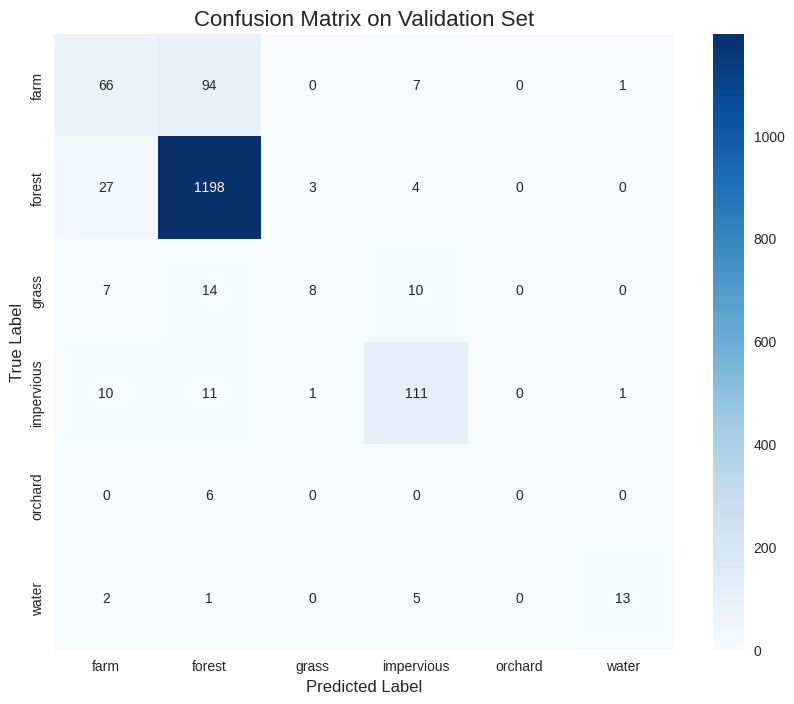

In [41]:
# ========================================================
# 6. MODEL EVALUATION ON A VALIDATION SET
# This is the correct way to estimate the model's performance
# ========================================================

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

print("\n--- Evaluating Model Performance on a Validation Set ---")

# Split the full training data into a new training set and a validation set (80/20 split)
# We use 'stratify' to ensure the class distribution is the same in both splits, which is crucial.
X_train_val, X_val, y_train_val, y_val = train_test_split(
    X_train_selected, 
    y_train_encoded, 
    test_size=0.20, 
    random_state=42, 
    stratify=y_train_encoded
)

print(f"Validation Training Set Shape: {X_train_val.shape}")
print(f"Validation Test Set Shape: {X_val.shape}")

# Train a new model instance ONLY on the 80% training split
validation_model = LogisticRegression(
    multi_class='multinomial', 
    solver='sag',
    C=100, 
    max_iter=1000, 
    random_state=42
)
validation_model.fit(X_train_val, y_train_val)

# Make predictions on the 20% validation set
y_val_pred = validation_model.predict(X_val)

# --- Calculate and Display Performance Metrics ---

# 1. Accuracy Score
accuracy = accuracy_score(y_val, y_val_pred)
print(f"\nModel Accuracy on Validation Set: {accuracy * 100:.2f}%")

# 2. Detailed Classification Report
# This shows precision, recall, and f1-score for each class
print("\nDetailed Classification Report:")
# Use 'target_names' to show class names instead of numbers
class_names = label_encoder.classes_
print(classification_report(y_val, y_val_pred, target_names=class_names))

# 3. Confusion Matrix
# This shows where the model is getting confused
print("Visualizing Confusion Matrix...")
cm = confusion_matrix(y_val, y_val_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix on Validation Set', fontsize=16)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.show()
